**CharCNN**

Евгений Борисов <esborisov@sevsu.ru>


построим простую языковая модель и
обучим её предсказывать последнюю букву в слове


----

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

%precision 3
np.set_printoptions(precision=3)
np.set_printoptions(linewidth=110)
# np.get_printoptions()

# загружаем тексты

In [2]:
# загружаем тексты
import gzip
import requests
from bs4 import BeautifulSoup

In [3]:
url='http://az.lib.ru/d/dostoewskij_f_m/text_0080.shtml'
text = BeautifulSoup(requests.get(url).text).get_text()
with gzip.open('dostoewskij.txt.gz','wt') as f: f.write(text)

# with gzip.open('dostoewskij.txt.gz','rt') as f: text = f.read()

text = text[2876:-664184].strip() # выкидываем заголовок и хвост страницы 
print(f'символов:{len(text)}\n---------------\n'%())
print(text[:355])

символов:1279540
---------------

Приступая к описанию недавних и столь странных событий, происшедших в нашем, доселе ничем не отличавшемся городе, я принужден, по неумению моему, начать несколько издалека, а именно некоторыми биографическими подробностями о талантливом и многочтимом Степане Трофимовиче Верховенском. Пусть эти подробности послужат лишь введением к предлагаемой хронике, 


----

In [4]:
data_size = 1024
offset = rng.randint( len(text) - data_size )
text_ = text[offset:offset+data_size]
print(text_)

будто бы презирала меня за перемену убеждений. Кого ж я бросил? Врагов живой жизни; устарелых либералишек, боящихся собственной независимости; лакеев мысли, врагов личности и свободы, дряхлых проповедников мертвечины и тухлятины! Что у них: старчество, золотая средина, самая мещанская, подлая бездарность, завистливое равенство, равенство без собственного достоинства, равенство, как сознает его лакей или как сознавал француз девяносто третьего года*...А главное, везде мерзавцы, мерзавцы и мерзавцы!
   - Да, мерзавцев много, -- отрывисто и болезненно проговорила она. Она лежала протянувшись, недвижимо и как бы боясь пошевелиться, откинувшись головой на подушку, несколько вбок, смотря в потолок утомленным, но горячим взглядом. Лицо ее было бледно, губы высохли и запеклись.
   - Ты сознаешь, Marie, сознаешь! - воскликнул Шатов. Она хотела было сделать отрицательный знак головой, и вдруг с нею сделалась прежняя судорога. Опять она спрятала лицо в подушку и опять изо всей силы целую минуту с

# собираем генератор дататасета

Xiang Zhang, Junbo Zhao, Yann LeCun    
Character-level Convolutional Networks for Text Classification. (2015)    
https://arxiv.org/abs/1509.01626

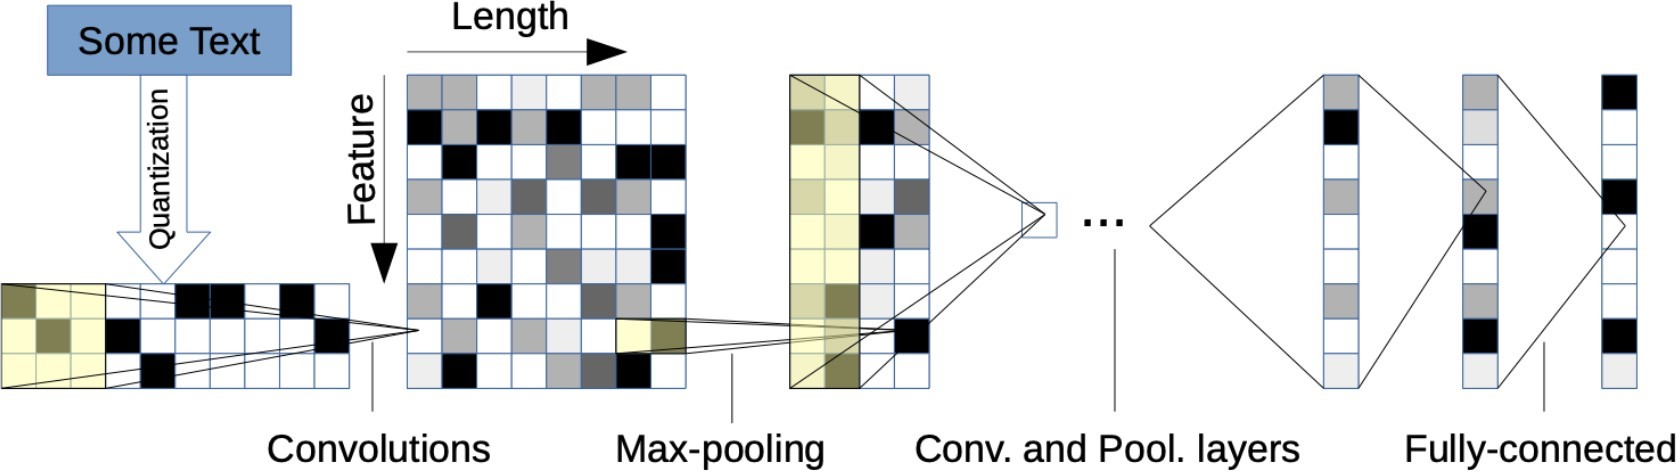


In [5]:
import torch
import torch.nn.functional as F

In [6]:
from torch.utils.data import Dataset

In [7]:
class CharMapDataset(Dataset):
    
    def __init__(self,text,contex_len,w_step=1):
        super().__init__()
        assert len(text)>1

        abc = sorted(set(text))
        self._vocabulary = { c:n for n,c in enumerate(abc) }
        self._data = np.array([
                self._encode(text[n:n+contex_len+1]) for n in range(0,len(text)-(contex_len+1),w_step) 
            ],dtype=int)
        
    @property
    def vocabulary(self): 
        return self._vocabulary
    
    def __getitem__(self, idx): # выдать элемент датасета номер idx
        return ( 
            torch.unsqueeze(
                F.one_hot( 
                        torch.tensor( self._data[idx,:-1], dtype=torch.long ), 
                        num_classes=len(self._vocabulary) 
                    ).to( torch.float32 ) 
            ,dim=0),
            F.one_hot( 
                    torch.tensor( self._data[idx,-1], dtype=torch.long ), 
                    num_classes=len(self._vocabulary) 
                ).to( torch.float32 ) ,
            
            # torch.tensor( self._one_hot( self._data[idx,-1] ), dtype=torch.float32 )
            # torch.tensor( self._data[idx,-1], dtype=torch.long ),  
        )

    # заменить в последовательности все токены на их номера в словаре
    def _encode(self,w):
        return [ self._vocabulary[c] for c in w if (c in self._vocabulary) ]
        
    # размер датасета
    def __len__(self): 
        return len(self._data)   
    
    # def _one_hot(self,x):        return np.eye(len(self._vocabulary))[x]

In [8]:
ds = CharMapDataset(text_,24,w_step=16)
display(len(ds) )
display(len(ds.vocabulary))
# display(ds.words)

63

55

In [9]:
from torch.utils.data import DataLoader
for x,t in DataLoader(ds,batch_size=16,shuffle=True): break
display((x.shape,t.shape))

(torch.Size([16, 1, 24, 55]), torch.Size([16, 55]))

In [11]:
# x

# строим модель

In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
class ModelCharCNN(nn.Module):
    
    def __init__(self, in_size, vocabulary,):
        super().__init__()
        self._vocabulary = vocabulary
        (h,w),c = in_size,1
        self._conv0  = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5)
        h,w,c = h-4,w-4,16
        self._mpool0 = nn.MaxPool2d(kernel_size=2)
        h,w = h//2,w//2
        self._conv1  = nn.Conv2d(in_channels=16,out_channels=24,kernel_size=5)
        h,w,c = h-4,w-4,24
        self._mpool1 = nn.MaxPool2d(kernel_size=2)
        h,w = h//2,w//2
        self._linear = nn.Linear( h*w*c, len(vocabulary) )

    def forward(self,x):
        o = self._conv0(x)
        o = F.relu(o)
        o = self._mpool0(o)
        o = self._conv1(o)
        o = F.relu(o)
        o = self._mpool1(o)
        o = torch.flatten(o,start_dim=1)
        o = self._linear(o) # считаем выход сети
        o = F.softmax(o,dim=-1)
        return o
    
    def predict(self,x):
        return torch.argmax( self.forward(x), dim=-1 , keepdims=True)
    
    @property
    def vocabulary(self): return self._vocabulary

In [14]:
# from torch.utils.data import DataLoader
# for x,t in DataLoader(ds,batch_size=16,shuffle=True): break
# display((x.shape,t.shape))

# _,_,h,w = x.shape

# model = ModelCharCNN(in_size=(h,w),vocabulary=ds.vocabulary)

# o = model.forward(x)
# display( o.shape )

# # o = model.predict(x)
# # display( o.shape )

# обучаем модель

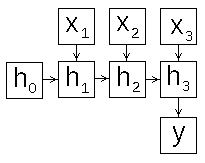

градиент функции потери - частные производные по всем параметрам модели, направление наискорейшего возрастания функции 

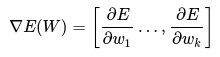


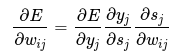

процедура обратного распространения ошибки

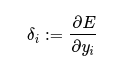

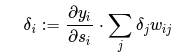

In [15]:
# проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
display( device )
display( torch.cuda.get_device_name() )

device(type='cuda', index=0)

'Tesla P40'

In [16]:
from torch.utils.data import DataLoader
for x,t in DataLoader(ds,batch_size=16,shuffle=True): break
display((x.shape,t.shape))

_,_,h,w = x.shape

model = ModelCharCNN(in_size=(h,w),vocabulary=ds.vocabulary).to(device)

(torch.Size([16, 1, 24, 55]), torch.Size([16, 55]))

In [17]:
# ф-ция потери
criterion =  nn.BCELoss()
# criterion = nn.NLLLoss()

# метод оптимизации
optimizer = torch.optim.Adam( model.parameters(), lr=1e-3) 

In [18]:
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

In [19]:
loss_history = [] # значения ф-ции потери

In [20]:
%%time

n_epoch = 32 # количество эпох обучения

for i in tqdm(range(n_epoch)): 
    loss_batch = []
    # получаем батч учебных примеров
    for x,t in DataLoader( ds, batch_size=len(ds)//5, shuffle=True): 
        o = model.forward(x.to(device)) # считаем выход модели
        loss = criterion( o, t.to(device) ) # вычисляем значение ф-ции потери
        loss_batch.append( loss.item() ) # дополняем историю изменения значений ф-ции потери на батче
        optimizer.zero_grad() # очищаем предыдущее значение градиента
        loss.backward()  # вычисляем текущее значение градиента ф-ции потери
        optimizer.step() # корректируем параметры модели
    
    loss_history.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери
    if loss_history[-1]<1e-2: break

  0%|          | 0/32 [00:00<?, ?it/s]

CPU times: user 440 ms, sys: 55.6 ms, total: 496 ms
Wall time: 505 ms


Text(0.5, 1.0, 'min loss: 0.00860')

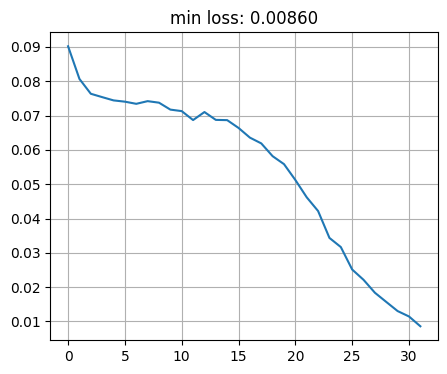

In [21]:
from matplotlib import pyplot as plt

fig,ax = plt.subplots(figsize=(5,4))
ax.plot(loss_history)
ax.grid()
ax.set_title(f'min loss: {min(loss_history):.5f}')

# тестируем

In [22]:
from sklearn.metrics import accuracy_score


for x,t in DataLoader(ds,len(ds)): break

with torch.set_grad_enabled(False): # генерируем следующий токен
    p = model.predict(x.to(device)).cpu().numpy() #.item()
        
target = np.argmax(t.numpy(),axis=-1).reshape(-1,1)

display( accuracy_score(y_true=target, y_pred=p ) )

0.968

In [23]:
import pandas as pd

In [24]:
def decode(x,vocabulary):
    v = { n:w for w,n in  vocabulary.items() }
    return [
        ''.join([ v[c] for c in s ])
        for s in x
    ]

In [25]:
import pandas as pd

# декодируем слова
df = pd.DataFrame({
         'sequence': decode( np.argmax(torch.squeeze(x).numpy(),axis=-1),ds.vocabulary),
           'target': decode(target,ds.vocabulary),
         'predicted': decode(p,ds.vocabulary)
    })

display(df)

,sequence,target,predicted
0,будто бы презирала меня,з,з
1,ла меня за перемену убеж,д,д
2,ену убеждений. Кого ж я,б,б
3,ого ж я бросил? Врагов ж,и,и
4,Врагов живой жизни; уста,р,р
...,...,...,...
58,. Опять она спрятала лиц,о,о
59,тала лицо в подушку и оп,я,я
60,шку и опять изо всей сил,ы,ы
61,всей силы целую минуту с,ж,ж
